In [2]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import random
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Question1

## Generate data

In [3]:
m0 = np.array([[-1]*4]).reshape(4,1)
c0 = np.array([[2,-0.5,0.3,0],
              [-0.5,1,-0.5,0],
              [0.3,-0.5,1,0],
              [0,0,0,2]])
m1 = np.array([[1]*4]).reshape(4,1)
c1 = np.array([[1,0.3,-0.2,0],
               [0.3,2,0.3,0],
               [-0.2,0.3,1,0],
               [0,0,0,3]])

c2 = np.array([[2,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])

c3 = np.array([[1,0,0,0],
               [0,2,0,0],
               [0,0,1,0],
               [0,0,0,3]])

In [4]:
rs = np.random.RandomState(233)
D0 = rs.multivariate_normal(m0.flatten(), c0, 10000)
D1 = rs.multivariate_normal(m1.flatten(), c1, 10000)
label = rs.binomial(1, 0.3, 10000).reshape(10000,1)
D = D0* (1-label) + D1*label

# Part A

In [772]:
class PartAVecGaussian(object):
    def __init__(self, m0, c0, m1, c1):
        n = m0.shape[0]
        c0_inv = np.linalg.inv(c0)
        c1_inv = np.linalg.inv(c1)
        constant0 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c0) ** (1/2))
        constant1 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c1) ** (1/2))
        
        self.cache = (c0, m0, c1, m1, c0_inv, c1_inv, constant0, constant1)
        
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, gamma):        
        c0, m0, c1, m1, c0_inv, c1_inv, constant0, constant1 = self.cache
    
        likelihood1 = self.get_gaussian(data, constant1, m1, c1_inv)
        likelihood0 = self.get_gaussian(data, constant0, m0, c0_inv)
        
        lhs = likelihood1 / likelihood0
        rhs = np.array(gamma)
        return 1 * (lhs[:,np.newaxis] > rhs[np.newaxis,:])

In [773]:
gamma_list = [0, 1e-16, 1e-12, 1e-8, 1e-4] + np.arange(0.0001, 0.001, 0.0001).tolist() + np.arange(0.001, 1, 0.001).tolist() + np.arange(1, 100, 0.01).tolist() + [1e2, 1e4, 1e8, 1e16, 1e64]
test_rule = PartAVecGaussian(m0, c0, m1, c1)
test_pred = test_rule(D, gamma_list)

In [774]:
tp_list = ((test_pred == 1) & (label == 1)).sum(axis=0) / label.sum()
fp_list = ((test_pred == 1) & (label == 0)).sum(axis=0) / (label == 0).sum()

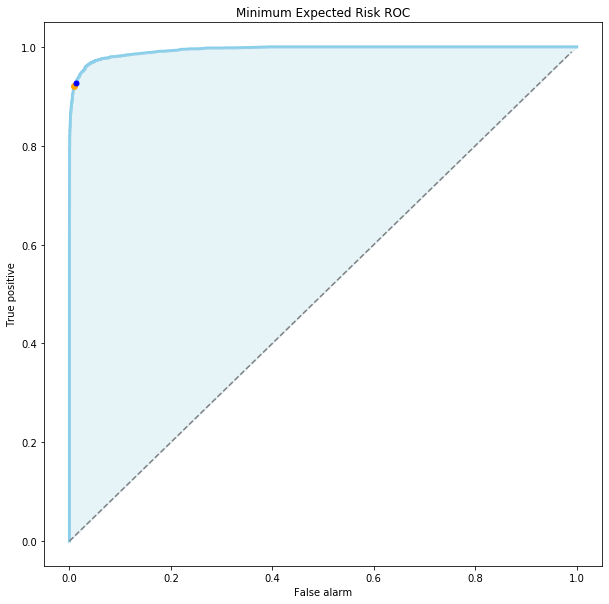

In [775]:
plt.figure(figsize=(10, 10))
plt.plot(fp_list, tp_list, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(fp_list, tp_list, fp_list, color='lightblue', alpha=0.3)
plt.title('Minimum Expected Risk ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin = np.argmin(np.array(fp_list) * 0.7 + np.array(1-tp_list) * 0.3)
plt.scatter(fp_list[argmin], tp_list[argmin], color='orange', zorder=10, s=35)
plt.scatter(theretical_fp, theretical_tp, color='blue', zorder=10, s=25)

In [776]:
erm_error = (1 - tp_list) * 0.3 + fp_list * 0.7
gamma_list[erm_error.argmin()], erm_error.min()

(3.200000000000002, 0.030115988792577264)

In [777]:
theoretical_gamma = 0.7 / 0.3
theoretical_pred = test_rule(D, [0.7/0.3])
theoretical_tp = ((theoretical_pred == 1) & (label == 1)).sum(axis=0) / label.sum()
theoretical_fp = ((theoretical_pred == 1) & (label == 0)).sum(axis=0) / (label == 0).sum()
theoretical_fp * 0.7 + (1- theoretical_tp)*0.3

array([0.03068097])

## Part B

In [778]:
nb_rule = PartAVecGaussian(m0, c2, m1, c3)
nb_pred = nb_rule(D, gamma_list)

In [779]:
nb_tp_list = ((nb_pred == 1) & (label == 1)).sum(axis=0) / label.sum()
nb_fp_list = ((nb_pred == 1) & (label == 0)).sum(axis=0) / (label == 0).sum()

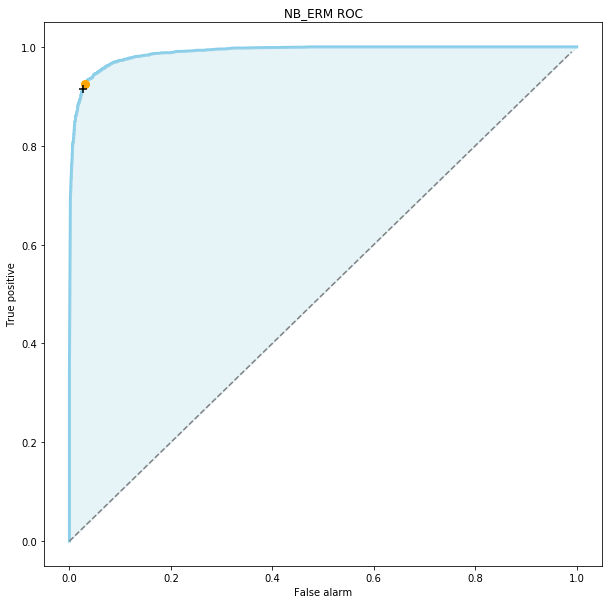

In [780]:
plt.figure(figsize=(10, 10))
plt.plot(nb_fp_list, nb_tp_list, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(nb_fp_list, nb_tp_list,nb_fp_list, color='lightblue', alpha=0.3)
plt.title('NB_ERM ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin_nb = np.argmin(np.array(nb_fp_list) * 0.7 + np.array(1-nb_tp_list) * 0.3)
plt.scatter(nb_fp_list[argmin_nb], nb_tp_list[argmin_nb], color='orange', zorder=10, s=65)
plt.scatter(theretical_NBfp, theretical_NBtp, color='black', zorder=10, s=65, marker = "+")

In [781]:
nb_error = (1 - nb_tp_list) * 0.3 + nb_fp_list * 0.7
gamma_list[nb_error.argmin()], nb_error.min()

(1.7500000000000007, 0.04376167086313333)

In [782]:
theoretical_NbPred = nb_rule(D, [0.7/0.3])
theoretical_NBtp = ((theoretical_NbPred == 1) & (label == 1)).sum(axis=0) / label.sum()
theoretical_NBfp = ((theoretical_NbPred == 1) & (label == 0)).sum(axis=0) / (label == 0).sum()
theoretical_NBfp * 0.7 + (1-theoretical_NBtp)*0.3

array([0.04407823])

## Part C

In [783]:
import scipy.linalg as linalg
data0 = D[label[:,0] == 0]
data1 = D[label[:,0] == 1]
mu0 = data0.mean(axis=0)
mu1 = data1.mean(axis=0)
Sigma0 = ((data0 - mu0).T @ (data0 - mu0)) / data0.shape[0]
Sigma1 = ((data1 - mu1).T @ (data1 - mu1)) / data1.shape[0]

$\Sigma = \frac{1}{n}\sum_i^n{v_iv_iT}$

In [784]:
def LDA_classifier_eigenvector(mu0, mu1, Sigma0, Sigma1):
    Sb = np.einsum('x, y -> xy', mu0 - mu1, mu0 - mu1)
    Sw = Sigma0 + Sigma1
    evalue, evec = linalg.eigh(Sb, Sw)
    return evec[:,np.argmax(evalue)].reshape(mu0.shape[0],1)

In [785]:
w = LDA_classifier_eigenvector(mu0, mu1, Sigma0, Sigma1)

In [786]:
def LDA_classifier(data, w, gamma_list_lda):
    lda_preds = np.einsum('du, nd -> nu', w, data)
    return 1 * (lda_preds > gamma_list_lda)

In [787]:
gamma_list_lda = np.arange(-4, 5, 0.05)
pr_label = LDA_classifier(D,w,gamma_list_lda)

In [788]:
def calc_tp_LDA(pred, gt):
    count = (pred & gt == 1).sum(axis=0) 
    return count / gt.sum()
    
def calc_fp_LDA(pred, gt):
    count = ((pred == 1)&(gt == 0)).sum(axis=0)
    return count / (gt == 0).sum()

In [789]:
lda_tp_list = calc_tp_LDA(pr_label, label)
lda_fp_list = calc_fp_LDA(pr_label, label)

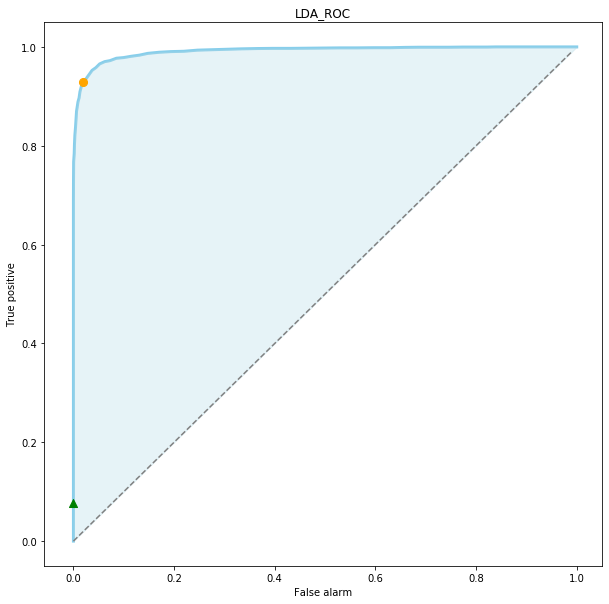

In [790]:
plt.figure(figsize=(10, 10))
plt.plot(lda_fp_list, lda_tp_list, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(lda_fp_list, lda_tp_list, lda_fp_list, color='lightblue', alpha=0.3)
plt.title('LDA_ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin_lda = np.argmin(np.array(lda_fp_list) * 0.7 + np.array(1 - lda_tp_list) * 0.3)
plt.scatter(lda_fp_list[argmin_lda], lda_tp_list[argmin_lda], color='orange', zorder=10, s=65)
plt.scatter(lda_fp_theretical, lda_tp_theretical, color='green', marker = "^",zorder=10, s=65)


In [791]:
lda_error = (1 - lda_tp_list) * 0.3 + lda_fp_list * 0.7
gamma_list[lda_error.argmin()], lda_error.min()

(0.067, 0.03431659441880304)

In [792]:
pred_theoretical = LDA_classifier(D,w,0.7/0.3)
lda_tp_theoretical = calc_tp_LDA(pred_theoretical, label)
lda_fp_theoretical = calc_fp_LDA(pred_theoretical, label)
lda_fp_theoretical * 0.7 + (1 - lda_tp_theoretical) * 0.3

array([0.27662083])

# Quetion 2

## part A

## Generate data

In [793]:
M1 = np.array([1,-1,-1]).reshape(3,1)
M2 = np.array([1,1,-1]).reshape(3,1)
M3 = np.array([-1,1,-1]).reshape(3,1)
M4 = np.array([-1,-1,-1]).reshape(3,1)
loss_value_matrix = np.array([[0,1,2,3],
                             [10,0,5,10],
                             [20,10,0,1],
                             [30,20,1,0]])
CorMat1 = np.array([[0.12,0,0],
                    [0,0.12,0],
                    [0,0,0.12]])
CorMat2 = np.array([[0.14,0,0],
                    [0,0.14,0],
                    [0,0,0.14]])
CorMat3 = np.array([[0.16,0,0],
                    [0,0.16,0],
                    [0,0,0.16]])
CorMat4 = np.array([[0.18,0,0],
                    [0,0.18,0],
                    [0,0,0.18]])
d1 = rs.multivariate_normal(M1.flatten(), CorMat1, 10000)
d2 = rs.multivariate_normal(M2.flatten(), CorMat2, 10000)
d3 = rs.multivariate_normal(M3.flatten(), CorMat3, 10000)
d4 = rs.multivariate_normal(M4.flatten(), CorMat4, 10000)

In [794]:
manul_label = [1]*2000 + [2]*2500 + [3]*2500 + [4]*3000
random.shuffle(manul_label)
label = np.array(manul_label).reshape(10000,1)
data = d1 * (label == 1) + d2 * (label == 2) + d3 * (label == 3) + d4 * (label == 4)

In [795]:
class PartBVecGaussian(object):
    def __init__(self, M1, CorMat1, M2, CorMat2, M3, CorMat3, M4, CorMat4):
        n = M1.shape[0]
        c1_inv = np.linalg.inv(CorMat1)
        c2_inv = np.linalg.inv(CorMat2)
        c3_inv = np.linalg.inv(CorMat3)
        c4_inv = np.linalg.inv(CorMat4)
        constant1 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat1) ** (1/2))
        constant2 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat2) ** (1/2))
        constant3 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat3) ** (1/2))
        constant4 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat4) ** (1/2))
        self.cache = (M1,CorMat1,M2,CorMat2,M3,CorMat3,M4,CorMat4,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4)
        
                     
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, p1, p2, p3, p4):        
        M1,CorMat1,M2,CorMat2,M3,CorMat3,M4,CorMat4,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4 = self.cache
    
        likelihood1 = (self.get_gaussian(data, constant1, M1, c1_inv) * p1).tolist()
        likelihood2 = (self.get_gaussian(data, constant2, M2, c2_inv) * p2).tolist()
        likelihood3 = (self.get_gaussian(data, constant3, M3, c3_inv) * p3).tolist()
        likelihood4 = (self.get_gaussian(data, constant4, M4, c4_inv) * p4).tolist()
        
        return np.argmax(np.array([likelihood1,likelihood2,likelihood3,likelihood4]), axis = 0) + 1
    

In [796]:
MAP_rule = PartBVecGaussian(M1, CorMat1, M2, CorMat2, M3, CorMat3, M4, CorMat4)
pred_MAP = MAP_rule(data,0.2,0.25,0.25,0.3).reshape(10000,1)

In [797]:
label1 = (label==1).reshape(10000,)
label2 = (label==2).reshape(10000,)
label3 = (label==3).reshape(10000,)
label4 = (label==4).reshape(10000,)

In [798]:
label1T = ((label==1) & (pred_MAP == 1)).flatten()
label1F = ((label==1) & (pred_MAP != 1)).flatten()
label2T = ((label==2) & (pred_MAP == 2)).flatten()
label2F = ((label==2) & (pred_MAP != 2)).flatten()
label3T = ((label==3) & (pred_MAP == 3)).flatten()
label3F = ((label==3) & (pred_MAP != 3)).flatten()
label4T = ((label==4) & (pred_MAP == 4)).flatten()
label4F = ((label==4) & (pred_MAP != 4)).flatten()

In [799]:
a = (label == 1) & (pred_MAP ==2)
confusion_matrix(label,pred_MAP)

array([[1988,    0,    0,   12],
       [  11, 2479,   10,    0],
       [   0,   14, 2464,   22],
       [  11,    0,   22, 2967]])

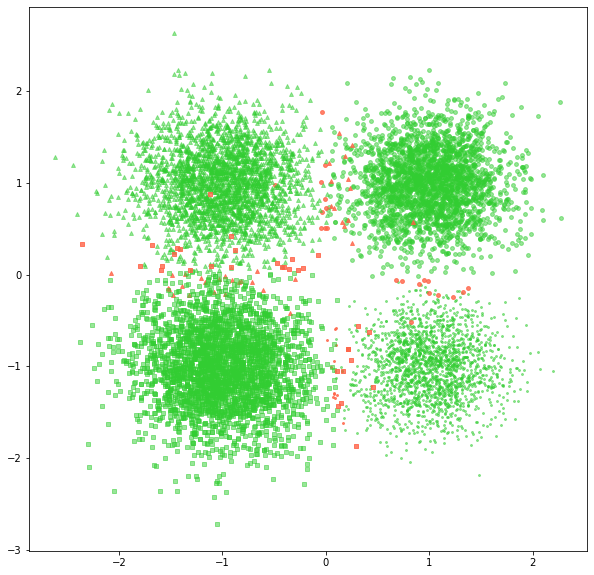

In [800]:
plt.figure(figsize=(10, 10))
plt.scatter(data[label1T][:,0], data[label1T][:,1], color='limegreen', s = 15, marker = ".", alpha=0.5)
plt.scatter(data[label1F][:,0], data[label1F][:,1], color='tomato', s = 15, marker = ".", alpha=0.8)

plt.scatter(data[label2T][:,0], data[label2T][:,1], color='limegreen', s = 15, marker = "o", alpha=0.5)
plt.scatter(data[label2F][:,0], data[label2F][:,1], color='tomato', s = 15, marker = "o", alpha=0.8)

plt.scatter(data[label3T][:,0], data[label3T][:,1], color='limegreen', s = 15, marker = "^", alpha=0.5)
plt.scatter(data[label3F][:,0], data[label3F][:,1], color='tomato', s = 15, marker = "^", alpha=0.8)

plt.scatter(data[label4T][:,0], data[label4T][:,1], color='limegreen', s = 15, marker = "s", alpha=0.5)
plt.scatter(data[label4F][:,0], data[label4F][:,1], color='tomato', s = 15, marker = "s", alpha=0.8)

In [801]:
class PartBVecGaussian_lossvalue(object):
    def __init__(self, M1, CorMat1, M2, CorMat2, M3, CorMat3, M4, CorMat4):
        n = M1.shape[0]
        c1_inv = np.linalg.inv(CorMat1)
        c2_inv = np.linalg.inv(CorMat2)
        c3_inv = np.linalg.inv(CorMat3)
        c4_inv = np.linalg.inv(CorMat4)
        constant1 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat1) ** (1/2))
        constant2 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat2) ** (1/2))
        constant3 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat3) ** (1/2))
        constant4 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(CorMat4) ** (1/2))
        self.cache = (M1,CorMat1,M2,CorMat2,M3,CorMat3,M4,CorMat4,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4)
        
                     
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, p1, p2, p3, p4, loss_value_matrix):        
        M1,CorMat1,M2,CorMat2,M3,CorMat3,M4,CorMat4,c1_inv,c2_inv,c3_inv,c4_inv,constant1,constant2,constant3,constant4 = self.cache
    
        likelihood1 = (self.get_gaussian(data, constant1, M1, c1_inv) * p1).tolist()
        likelihood2 = (self.get_gaussian(data, constant2, M2, c2_inv) * p2).tolist()
        likelihood3 = (self.get_gaussian(data, constant3, M3, c3_inv) * p3).tolist()
        likelihood4 = (self.get_gaussian(data, constant4, M4, c4_inv) * p4).tolist()
        likelihoodMatrix = np.array([likelihood1,likelihood2,likelihood3,likelihood4])
        return loss_value_matrix @ likelihoodMatrix


In [802]:
ERM_lossvalue_rule = PartBVecGaussian_lossvalue(M1, CorMat1, M2, CorMat2, M3, CorMat3, M4, CorMat4)
ExpRiskMatrix = ERM_lossvalue_rule(data,0.2,0.25,0.25,0.3,loss_value_matrix)
pred_label = (np.argmin((ExpRiskMatrix), axis = 0) + 1).reshape(10000,1)
np.min(ExpRiskMatrix,axis = 0).mean()

0.0006361885486683191

In [803]:
(confusion_matrix(label,pred_label) - confusion_matrix(label,pred_MAP)).T

array([[ 12,  43,  18,  20],
       [  0, -34,  -4,   0],
       [  0,  -9, -14,   1],
       [-12,   0,   0, -21]])

In [804]:
 confusion_matrix(label,pred_label)

array([[2000,    0,    0,    0],
       [  54, 2445,    1,    0],
       [  18,   10, 2450,   22],
       [  31,    0,   23, 2946]])

In [805]:
label_1T = ((label==1) & (pred_label == 1)).flatten()
label_1F = ((label==1) & (pred_label != 1)).flatten()
label_2T = ((label==2) & (pred_label == 2)).flatten()
label_2F = ((label==2) & (pred_label != 2)).flatten()
label_3T = ((label==3) & (pred_label == 3)).flatten()
label_3F = ((label==3) & (pred_label != 3)).flatten()
label_4T = ((label==4) & (pred_label == 4)).flatten()
label_4F = ((label==4) & (pred_label != 4)).flatten()

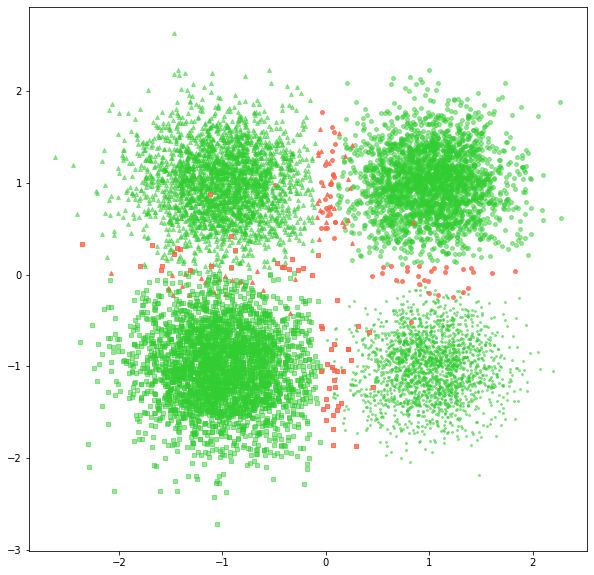

In [806]:
plt.figure(figsize=(10, 10))
plt.scatter(data[label_1T][:,0], data[label_1T][:,1], color='limegreen', s = 15, marker = ".", alpha=0.5)
plt.scatter(data[label_1F][:,0], data[label_1F][:,1], color='tomato', s = 15, marker = ".", alpha=0.8)

plt.scatter(data[label_2T][:,0], data[label_2T][:,1], color='limegreen', s = 15, marker = "o", alpha=0.5)
plt.scatter(data[label_2F][:,0], data[label_2F][:,1], color='tomato', s = 15, marker = "o", alpha=0.8)

plt.scatter(data[label_3T][:,0], data[label_3T][:,1], color='limegreen', s = 15, marker = "^", alpha=0.5)
plt.scatter(data[label_3F][:,0], data[label_3F][:,1], color='tomato', s = 15, marker = "^", alpha=0.8)

plt.scatter(data[label_4T][:,0], data[label_4T][:,1], color='limegreen', s = 15, marker = "s", alpha=0.5)
plt.scatter(data[label_4F][:,0], data[label_4F][:,1], color='tomato', s = 15, marker = "s", alpha=0.8)